## Heuristic 1
### Description

If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.

In [1]:
# Import relevant packages.

using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [2]:
# Environment settings for the notebook.
ENV["LINES"]=10
ENV["COLUMNS"]=10000;

In [68]:
# Load withdraw and deposit transactions data.

withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
withdraw_transactions_df[!, "recipient_address"] = lowercase.(withdraw_transactions_df[!, "recipient_address"])
select!(withdraw_transactions_df, Not(["Unnamed: 0", "Column1"]))

deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame)
select!(deposit_transactions_df, Not(["Unnamed: 0", "Column1"]));

In [71]:
first(deposit_transactions_df, 5)

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address
,String,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String
1,0xcf97c470a56d96625c7240d3004ae2abd9141d7ffc4383ab6f29a181e3562e8b,4,10,0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,56000000000,1677906,1048832,missing,missing,1,2020-11-02 17:47:30 UTC,11179130,0x21d86cba454fea4f7e43c68763d4cffec101b614554635a3f15d538049463d4f,missing,missing,missing,56000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
2,0x2fadc4d54bf6e3ec5035f14c0096befe92999866309893e0eeaecdef955c0323,22,118,0x6e92bc493c6abbdd6a1b18416f003de2c873ab50,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,63000000000,8209080,1048832,missing,missing,1,2021-01-02 23:37:35 UTC,11578054,0xd52ababd1dbbbe50277c54473c881f47fd95e78081a349670d4988644e4d37c4,missing,missing,missing,63000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
3,0x7baf0a76f35c1dece97fff883aa7174454bed460b1bade05844080017170fc6c,240,171,0x8c4c44fd06f7f98f08bf6a9ca156cec9ee1f31f8,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,800000,105000000000,10723996,800000,missing,missing,0,2021-01-06 19:04:40 UTC,11602841,0x7c5f21ea2a92f5182ce8648f152b6fb3b4379096309dc2ba232ac663c4a0d1d7,missing,missing,missing,105000000000,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144
4,0x7f851ba1d7292ca565961073a1111f7408760540c6f94e479c72a2ae05399cf4,0,84,0x50b9d4af009b038506d4d84b035c451d1a3a20bc,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,5000000000,8465851,800000,missing,missing,0,2020-01-05 05:19:39 UTC,9218451,0x77e0fc60906714a54697cfd9275b622ad9d2d0271c4ec816b10fa3a09b103680,missing,missing,missing,5000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
5,0xbd83053f8afa7777f54a4aca6b8e112fa31b888922dc5b9a9a65eb66e9a6996f,7,63,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,30838446643,6222489,800000,missing,missing,0,2020-05-27 03:30:44 UTC,10145408,0x837b3482443f027f6f045644bf002243f72304686015a2d6265676b2a2fc630b,missing,missing,missing,30838446643,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc


In [69]:
first(withdraw_transactions_df, 5)

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
,String,Int64,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String,String
1,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb92887517e20b237907e3,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,10382378,336384,missing,missing,1,2020-10-05 07:57:28 UTC,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be91cb80ee62d790714ab49,missing,missing,missing,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
2,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,7303106,339456,missing,missing,1,2020-02-11 19:10:54 UTC,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac065261de232dc502dfb756,missing,missing,missing,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
3,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f70c9a24e90f927672699,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,3211601,339456,missing,missing,1,2020-02-16 16:05:14 UTC,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290928b30f7defe0943381f,missing,missing,missing,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
4,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad11b91faa77bb852599b76,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,11795370,343296,missing,missing,1,2020-11-09 17:08:00 UTC,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaeef5fd5ca3fe9cb2d273ff,missing,missing,missing,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
5,0x30becee80e63a039102df3b1243e5d314534abfcf3ed0fc4eadb2dc5b1c45ab7,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,9771737,354304,missing,missing,1,2020-11-29 01:18:57 UTC,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e2f737a7c6b26b8781e56,missing,missing,missing,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b


### Function summary: addresses_to_transactions

Given a transactions DataFrame, returns a dictionary with the unique addresses of the transactions data as keys and a list of tuples as values. The tuples consist on the hash of the transaction with the address as the corresponding key in the first index, the timestamp of the transaction in the second index and the tornado cash pool that the address is interacting with in that specific transaction.

For example, if the address 0x6c6e4816ecfa4481472ff88 has made transaction with a hash 0x7f851ba1d7292ca565961073a111 that interacted with the 0.1 ETH pool at timestamp 1, and another transaction with hash 0x8f851ba1d7192ca565961073a9191 that interacted with the 1 ETH pool at timestamp 2, then the dictionary returned will be:

```
{"0x6c6e4816ecfa4481472ff88" => [("0x7f851ba1d7292ca565961073a111", timestamp1, "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc"), ("0x8f851ba1d7192ca565961073a9191", timestamp2, "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936")]
```

Note that "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936" is the 1 ETH address and "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc" the one of 0.1 ETH pool

In [70]:
function addresses_to_transactions(transactions_df)
    
    # Initialize empty dictionary to store addresses and associated transactions.
    
    address_to_transactions_dict = Dict{String, Vector{Tuple{String, String, String}}}()
    
    # We iterate over every transaction in the transactions DataFrame.
    
    for row in eachrow(transactions_df)

        """
        We check if the address of the current transaction in the iteration is already in the 
        dictionary. If it isn't, then we initialize that key and the list with the tuple. The
        tuple will consist of the hash and the timestamp of the current transaction.
        
        If the key already exists, we append to the associated list the tuple of the hash and
        timestamp of the current transaction.
        """
         
        if row.from_address ∉ Set(keys(address_to_transactions_dict))
            address_to_transactions_dict[row.from_address] = [(row.hash, row.block_timestamp, row.tornado_cash_address)]
        else
            push!(address_to_transactions_dict[row.from_address], (row.hash, row.block_timestamp, row.tornado_cash_address) )
        end
    
    end
    # The dictionary with the addresses and transactions is returned.
    return address_to_transactions_dict
end

addresses_to_transactions (generic function with 1 method)

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and a dictionary corresponding to what is returned by function addresses_to_transactions.

It returns a tuple:

* (True, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.

* (False, None): When no such deposit was found

In [6]:
function same_deposit_and_recipient_address_heuristic(withdraw_transaction, deposit_addresses_to_transactions)
    
    """
    Check if the address of the withdraw tx is in the deposit_addresses_to_transactions keys.
    If it is, then a list is created with the hashes of all the deposit txs with the same address and
    with an earlier timestamp than the withdraw tx.
    If the address is not in the deposit_addresses_to_transactions dictionary, (False, None) is returned.
    """
    
    if withdraw_transaction.recipient_address in Set(keys(deposit_addresses_to_transactions))
        
        # Only the transactions with earlier timestamps and same pool are selected for the list same_deposit_address_hashes.
        same_deposit_address_hashes = [tx_hash[1] for tx_hash in deposit_addresses_to_transactions[withdraw_transaction.recipient_address] if (tx_hash[2] <= withdraw_transaction.block_timestamp) && (tx_hash[3] == withdraw_transaction.tornado_cash_address)]
   
        # Final check to assert that list is not empty.
        if length(same_deposit_address_hashes) > 0
            return (true, same_deposit_address_hashes)
        else
            return (false, nothing)
        end
        
    end
        
    return (false, nothing)
end

same_deposit_and_recipient_address_heuristic (generic function with 1 method)


### Function summary: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction. Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.


In [7]:
function apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df)
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    deposit_addresses_and_transactions = addresses_to_transactions(deposit_transactions_df)
    
    same_deposit_address_hashes = Dict()
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
        
    for withdraw_row_tuple in eachrow(withdraw_transactions_df)
        deposit_hashes = same_deposit_and_recipient_address_heuristic(withdraw_row_tuple, deposit_addresses_and_transactions)
        if deposit_hashes[1]
            same_deposit_address_hashes[withdraw_row_tuple.hash] = deposit_hashes[2]
        end

    end
    
    # Return the dictionary with the links
    return same_deposit_address_hashes
end

apply_same_deposit_and_recpient_address_heuristic (generic function with 1 method)

In [8]:
hashes_dict = apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df);


In [82]:
Dict(collect(hashes_dict)[65])


Dict{Any, Any} with 1 entry:
  "0xd4be55eddbd3b8546b4266101edf5dcbb8c72985ff638b67089af4e051498362" => ["0x15d362cb79e23ec311b46bef4e8ffa7286da0c56e36fdcd1e66f40475cc94ab7", "0xf2431ddfbd7cc67589c5e14276a58e0812d7a19baf5178d057b554d3c0da2dfe", "0x64ec8c13fbd0c4df3128cc4dd3d0a53479877a0a13201a9a9e3fe35eac3e80a4"]

### Result visualization

In [9]:
# Count of deposit transactions linked to withdraws.
linked_deposits_count = map(x -> length(x), values(hashes_dict))

14284-element Vector{Int64}:
 200
  30
 135
   ⋮
   5
   5

In [10]:
length(linked_deposits_count)

14284

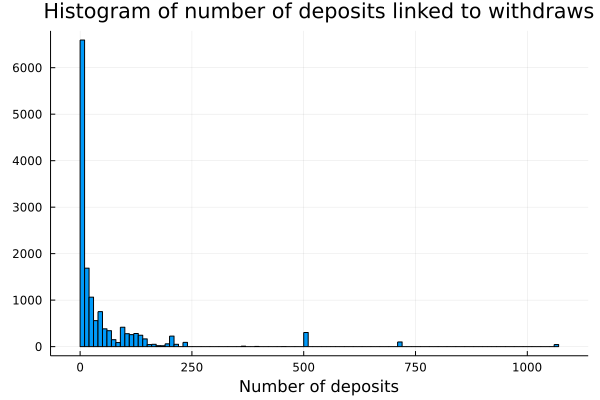

In [11]:
histogram(linked_deposits_count, bins=100, label = false)
title!("Histogram of number of deposits linked to withdraws")
xlabel!("Number of deposits")

## Heuristic 2

### Description

If there is a deposit and a withdraw transaction with **unique** gas prices (e.g., 3.1415926 Gwei), then we consider the deposit and the withdraw transactions linked. The corresponding deposit transaction can be removed from any other withdraw transaction’s anonymity set.

In [12]:
using DataFrames
using CSV

In [13]:
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [14]:
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame)

non_relayer_withdraw_transactions_df = filter(row -> row.from_address == row.recipient_address, withdraw_transactions_df);

### Function summary: filter_by_unique_gas_price

Given a transactions DataFrame, it returns a dictionary with the unique gas prices as keys and a tuple containing the hash of that transaction and the timestamp. For example,

```
{111000302: ("0x387fcd87a", timestamp1)
```

In [15]:
# Filters a transaction DataFrame, leaving only the rows that have unique gas_price.

function filter_by_unique_gas_price(transactions_df)
    unique_gas_prices = filter(row -> row.count==1, combine(groupby(transactions_df, :gas_price), nrow => :count))[!, "gas_price"]
    temp_df = filter(row -> row.gas_price ∈ unique_gas_prices, transactions_df)
    
    
    return Dict{Int, Tuple{String,String}}(
            (row.gas_price) => (row.hash, row.block_timestamp) for row in eachrow(temp_df)
            )

end

filter_by_unique_gas_price (generic function with 1 method)

### Function summary: filter_by_unique_gas_price_by_pool

Given a transactions DataFrame, it returns a dictionary with a tuple of the unique gas prices and tornado pool as keys and a tuple containing the hash of that transaction and the timestamp. For example, 

```
{(111000302, "0x24387248"): ("0x387fcd87a", timestamp1)

```

In [16]:
function filter_by_unique_gas_price_by_pool(transactions_df)
    unique_gas_prices_by_pool = filter(row -> row.count==1, combine(groupby(transactions_df, [:gas_price , :tornado_cash_address]), nrow => :count))[!, ["gas_price", "tornado_cash_address"]]
    
    
    # Tuple set with the values (gas_price, tornado_cash_address) is made to filter efficiently
    
    tuple_set = Set{Tuple{Int, String}}([(row.gas_price, row.tornado_cash_address) for row in eachrow(unique_gas_prices_by_pool)])
    
    # A dataframe of the transactions that verify having these unique gas price values by pool.
    
    temp_df = filter(iter_tuple -> (iter_tuple.gas_price, iter_tuple.tornado_cash_address) in tuple_set , deposit_transactions_df)
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return Dict{Tuple{Int,String}, Tuple{String,String}}((row.gas_price, row.tornado_cash_address) => (row.hash, row.block_timestamp) for row in eachrow(temp_df))
end

filter_by_unique_gas_price_by_pool (generic function with 1 method)

### Function summary: same_gas_price_heuristic

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits, as returned by the function filter_by_unique_gas_price.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [17]:
function same_gas_price_heuristic(withdrawal_transaction, unique_gas_price_deposit_dict)
    
    """
    Check if the gas price of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    """
    
    if withdrawal_transaction.gas_price in Set(keys(unique_gas_price_deposit_dict)) && (unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][2] < withdrawal_transaction.block_timestamp)
        return (true, unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][1])
    else
        return (false, nothing)
    end
end

same_gas_price_heuristic (generic function with 1 method)

### Function summary: same_gas_price_heuristic_by_pool

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits made in each pool, just as returned by the function filter_by_unique_gas_price_by_pool.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price and belonging from the same pool (for example, 1ETH) as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [18]:
function same_gas_price_heuristic_by_pool(withdrawal_transaction, unique_gas_price_deposit_dict)
    
    """
    Check if the pair (gas_price, tornado_pool) of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    """
    
    if (withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address) in Set(keys(unique_gas_price_deposit_dict)) && (unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][2] < withdrawal_transaction.block_timestamp)
        return (true, unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][1])
    else  
        return (false, nothing)
    end
end

same_gas_price_heuristic_by_pool (generic function with 1 method)

### Function summary: apply_same_gas_price_heuristic

Applies the heuristic to all the withdraw_transactions DataFrame. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [19]:
function apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df)
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = Dict()
    
    # Iterate over the withdraw transactions.
    for withdraw_row in eachrow(withdraw_transactions_df)
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[1]
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[2]
        end
    end

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit
end

apply_same_gas_price_heuristic (generic function with 1 method)

### Function summary: apply_same_gas_price_heuristic_by_pool

Applies the heuristic to all the withdraw_transactions DataFrame, filtering also by the particular pool. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [20]:
function apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, withdraw_transactions_df)
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price_by_pool(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = Dict()
    
    # Iterate over the withdraw transactions.
    for withdraw_row in eachrow(withdraw_transactions_df) 
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic_by_pool(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[1]
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[2]
        end
    end

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit
end

apply_same_gas_price_heuristic_by_pool (generic function with 1 method)

We run the heuristic for the entire withdraw dataset

In [21]:
linked_transactions = apply_same_gas_price_heuristic(deposit_transactions_df, non_relayer_withdraw_transactions_df)

Dict{Any, Any} with 128 entries:
  "0x571a9c4a9d2a2b0386285e048073a8d48e995f2b5a3b5cd36734023f06e45a44" => "0x35a464d0e00fc398607b092f7b3186cd6c8ec0c82f6f4b6d9978c71221647671"
  "0x99b09453c62a24b9b7f78c27b37d1c06c2b9a64285412bf7e73609746a00abc0" => "0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72"
  "0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd" => "0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f"
  "0x02a1c2250c4dea47f8f38f262ea723ff54de15e8ff6f4de9b19938757800868f" => "0x04e9849765f104c250e6da696b16fd2be7f0eca3254038c0ba21049b061b3748"
  "0x197b4399402095682fd725c4fa7ce23450f1ffb4bd651dbe4f992b231f61160e" => "0x988638a03002b0bdf7023fdc03c0e7f9fdb7a493a913dc5b5bfc7e5c3c26f3db"
  ⋮                                                                    => ⋮

In [22]:
linked_transactions = DataFrame([collect(keys(linked_transactions)), collect(values(linked_transactions))], ["withdraw_hashes","deposit_hashes"])

,withdraw_hashes,deposit_hashes
,Any,Any
1,0x571a9c4a9d2a2b0386285e048073a8d48e995f2b5a3b5cd36734023f06e45a44,0x35a464d0e00fc398607b092f7b3186cd6c8ec0c82f6f4b6d9978c71221647671
2,0x99b09453c62a24b9b7f78c27b37d1c06c2b9a64285412bf7e73609746a00abc0,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72
3,0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd,0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f
4,0x02a1c2250c4dea47f8f38f262ea723ff54de15e8ff6f4de9b19938757800868f,0x04e9849765f104c250e6da696b16fd2be7f0eca3254038c0ba21049b061b3748
5,0x197b4399402095682fd725c4fa7ce23450f1ffb4bd651dbe4f992b231f61160e,0x988638a03002b0bdf7023fdc03c0e7f9fdb7a493a913dc5b5bfc7e5c3c26f3db
6,0x3e7734771217c28f9fc6d5b412ab35b4f8554b22fa5bb4d59789a981d15cde34,0x425066c1edecb08e72b81b7e32cb01e9637cbd0e8442bc4ee06d071ce2690340
7,0x0ee6d471ad8bb4217ed0e416e2c51af2d6e486e0f3fe5ac187e0488add7b2a60,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72
8,0x2d9649c3437d75adf66be1e2aa0a20858fafc4bfdc9d591a643ae8c074e6fc64,0xb3df9977fcf74b589dac668cb4fb360732f76edb72d1a779c7e4ef57265d89cd
9,0x523ec14086e2788e60f3ec20bf57450a41175dd4d76990acf675199a145471d4,0x7f21ef508a9bfafb030071da5f98db43981d7ea5405fd327a46dafdb6f10b4c0


Now we run the heuristic that filters by pool, again applying it to the entire withdraw dataset.

In [23]:
linked_transactions_by_pool = apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, non_relayer_withdraw_transactions_df)

Dict{Any, Any} with 172 entries:
  "0x185124e22a1f913f3f71db70fc38d7ae56cd2e671bc08ebcd44d2de6f488cdbe" => "0xf72d23287b3bf7dfc53633e3be0f728d9d5068eadb927eb79045d31d34f6538d"
  "0xc1b92522a23530412f24c0edfe62be443d8d0c3217562ca184505249e0235bba" => "0x936d0599d352096cdfcc1df76c3a027ce3ff2d835cd0b3030e7aaa688ce2fdcb"
  "0x88fde9e123ac0a9b011428ffb713c424c8aa8c5980a23fb7d8f2ba157f50d29e" => "0x0e1295215085d3f9e4799e8fd2a70fba45ce15dad27e284b71a503a630f5f542"
  "0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd" => "0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f"
  "0x4ce400034e4118bb1f57613ab19bb3b4697e1a569abe34b50a4ee26d03af6bd0" => "0x536caff3cb304258ddd02281f9122b73e1a0e2f24a6e102e45ab293b2cdc14a1"
  ⋮                                                                    => ⋮

In [24]:
linked_transactions_by_pool = DataFrame([collect(keys(linked_transactions_by_pool)), collect(values(linked_transactions_by_pool))], ["withdraw_hashes","deposit_hashes"])

,withdraw_hashes,deposit_hashes
,Any,Any
1,0x185124e22a1f913f3f71db70fc38d7ae56cd2e671bc08ebcd44d2de6f488cdbe,0xf72d23287b3bf7dfc53633e3be0f728d9d5068eadb927eb79045d31d34f6538d
2,0xc1b92522a23530412f24c0edfe62be443d8d0c3217562ca184505249e0235bba,0x936d0599d352096cdfcc1df76c3a027ce3ff2d835cd0b3030e7aaa688ce2fdcb
3,0x88fde9e123ac0a9b011428ffb713c424c8aa8c5980a23fb7d8f2ba157f50d29e,0x0e1295215085d3f9e4799e8fd2a70fba45ce15dad27e284b71a503a630f5f542
4,0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd,0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f
5,0x4ce400034e4118bb1f57613ab19bb3b4697e1a569abe34b50a4ee26d03af6bd0,0x536caff3cb304258ddd02281f9122b73e1a0e2f24a6e102e45ab293b2cdc14a1
6,0xc4b5fc604fbddc059d9f734a6cd215da7a8396c78f3f40191081e2307db135f4,0x9da5cc9fd17e1f8f75a921dc0974fb7cf1d24077b5332a9630ca62c21e1263b3
7,0x4c5682d081e3085062c5f59bd29da9b80870fac27c94db1d4b58c443507dabbe,0xac60db623d36ab867f39572d07972b46809a7c7ceec8c852255bbb3730e0c5bf
8,0x0fae022876b43a8ffbf966b3135d935db856203d9862b1f560b9f75c9c2c2158,0xe70dd917d26dea5e9a668b1b6b87fef1baf5cdc0367e72211512a28fa51f7b04
9,0x1e84a2a314747ef8617b8ae62d0aa21058c8eab8e311d9100f376e88f870f13b,0x3e7dd307c469ded667789467b1feb3c9b263301ef862b833c01791944bf2f6a2


## Heuristic 3 - Transactions outside TCash

### Overview
The main goal of this heuristic is to link Ethereum accounts which interacted with TCash by inspecting Ethereum transactions outside it. 

This is done constructing two sets, one corresponding to the unique TCash deposit addresses ($S_{D}$) and one to the unique TCash withdraw addresses ($S_{W}$), to then make a query to reveal transactions between addresses of each set.

Withdraw transactions are inspected one by one, searching for Ethereum transactions done between the withdraw address and any of the deposit addresses. When such a transaction is found, the withdraw transaction is linked with all the deposits of the deposit addresses that were done before the withdraw.


### Data
The query to the public BigQuery database was done like so,

```
INSERT `tornado_cash_transactions.transactions_between_withdraw_and_deposit_addresses` 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions`
WHERE 
    (
       (`from_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
       AND 
       (`to_address` IN ( SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
    )
    OR
    (
       (`from_address` IN (  SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
       AND 
       (`to_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
    )
```

The resulting table has two columns, **from_address** and **to_address**, and each row corresponds to a transaction done between a TCash deposit address and a TCash withdraw address, outside TCash.
From this table, we want to know which of the two addresses was the one that made the deposit and which one made the withdraw. In this way, we are able to link the corresponding deposit and withdraw transactions.

For example, consider this entry from the resulting table,

| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |

Suppose that `address1` is an address that withdrawed in TCash and `address2` one that made a deposit. Then, we want to transform said entry to one with colums **deposit_address** and **withdraw_address** like so,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |

With this new table, it is straightforward to make de linking between TCash transactions. With it, we can create a mapping to know with what deposit addresses each withdraw address interacted with.


### Some definitions 
A problem raises when there are addresses that belong to the two sets of TCash addresses $S_{D}$ and $S_{W}$.
Let us define an address of type `D` when it belongs to $S_{D}$ and not to $S_{W}$.
Likewise, an address of type `W` is defined when it belongs to $S_{W}$ and not to $S_{D}$. 
Finally, when an address belongs to both sets, we classify it as a `DW` type.

For the cases where we got outside TCash transactions of type `D -> W` (i.e., a transaction from a *D* type address to a *W* type address) or `W -> D` (i.e., a transaction from a *W* type address to a *D* type address), it is trivial to transform this entry to the new table.

In the cases where we have transactions of type `DW -> W`, `DW -> D`, `W -> DW` and `D -> DW`, it is also straightforward to transform the corresponding entries. For example, consider again this particular entry of Ethereum transactions table,


| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |


Suppose now that `address1` is of type `DW` and `address2` of type `D`. Then, `address2` is trivially placed in the `deposit_address` column. By a process of elimination, then `address1` is set in `withdraw_address` column,


| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |


When we have a transaction of type `DW -> DW`, it cannot be known which address deposited and which one made the withdraw, so the two combinations are considered. Considering again the same entry, the resulting table will be as follows,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address1        | address2         |
| address2        | address1         |


Then, deposits of `address1` are linked to withdraws of `address2` and deposits of `address2` are linked to withdraws of `address1`.


### Results data structure
The results of this heuristic are returned as a dictionary where each element has a TCash withdraw transaction hash  as key and a list of the linked TCash deposit transaction hashes as a value. For example,

```
    '0x4858': ['0x2fad', '0x750a']
```
This would mean that withdraw transaction `0x4858` is linked to `0x2fad` and `0x750a` deposit transactions.

In [25]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [26]:
using CSV
using DataFrames
using ProgressBars
using JSON


In [27]:
# Utils functions 
function load_addresses_and_pools_to_deposits_json(filepath)
    raw_dict_list = JSON.parsefile(filepath)
    addresses_and_pools_to_deposits = Dict{@NamedTuple{address::String, pool::String}, Vector{@NamedTuple{deposit_hash::String, timestamp::String}}}()
        
        for dic in raw_dict_list
            addresses_and_pools_to_deposits[(address=dic["key"][1], pool=dic["key"][2])] = [(deposit_hash=l[1], timestamp=l[2]) for l in dic["value"]]
        end
    
    return addresses_and_pools_to_deposits
end

load_addresses_and_pools_to_deposits_json (generic function with 1 method)

In [28]:
tornado_addresses = JSON.parsefile("../data/tornado_pools.json")
deposit_txs = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame)
deposit_txs.tcash_pool = [tornado_addresses[addr] for addr in deposit_txs.tornado_cash_address]

withdraw_txs = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
withdraw_txs.tcash_pool = [tornado_addresses[addr] for addr in withdraw_txs.tornado_cash_address]

const unique_deposit_addresses = Set(deposit_txs[!, :from_address])
const unique_withdraw_addresses = Set(withdraw_txs[!, :recipient_address])

addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json("../data/addresses_and_pools_to_deposits.json")

outside_tcash_txs = CSV.read("../data/transactions_between_deposit_and_withdraw_addresses.csv", DataFrame)
address_and_withdraw_df = outside_tcash_txs[!, [:from_address, :to_address]];

### Data preprocessing
From the data obtained in the query, we want to filter repeated and permuted transactions, since they don't provide any new information. Once a transaction between a withdraw address and a deposit address is found, they are considereded linked regardless of the direction in what the transaction was done and the number of times they interacted.

In [29]:
function filter_repeated_and_permuted(address_and_withdraw_df)
    filtered_addresses_set = Set(Set([]))
    
    for row in eachrow(address_and_withdraw_df)
        push!(filtered_addresses_set, Set([row.from_address, row.to_address]))
    end
  
    filtered_addresses_set
end

function dataframe_from_set_of_sets(set_of_sets)
    df = DataFrame(address_1=[], address_2=[])
    for set in set_of_sets
        push!(df, collect(set))
    end
    df
end

function preprocess_data(address_and_withdraw_df)
    set = filter(x -> length(x) == 2, filter_repeated_and_permuted(address_and_withdraw_df))
    dataframe_from_set_of_sets(set)
end

preprocess_data (generic function with 1 method)

In [30]:
clean_addresses = preprocess_data(address_and_withdraw_df)

,address_1,address_2
,Any,Any
1,0x0c63d55a244657f5606d62856bd9f1ff227c05f2,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
2,0xd9ee088c6ca2a90d6f0d059af17c2ec2c908bb0f,0xc73ef94bc339a2cb9a1b67820af46bf47484a1ed
3,0xbf7c205febae32f7874b28b9f371fe522e1fd97a,0xe5b5df72187f7d867973615f5e1144b7a95b495f
4,0x35f081bdf4740ffa8a56ff98e4b971fbcb7d82a7,0x09fe8f71f8e14b3d6b6456fbafaaef4a27f042cd
5,0xa8308e994d180ca87c6a784fcb8612dec9ede03d,0x46ba0af6bc60e6fabd9957744c057d031c720ace
6,0xf62e92b2452d8a0fbb2c4b03424d679c86660001,0xf94571dbdff33446dabd17040cd6236b0d2c2545
7,0xce91fddab3c544b59ebac665a7635561043a7def,0x865ec62a7f46aab0976ad22573fcf319c3f939ce
8,0x134b9eab4aa4c1489687c18c10d7338656fde32d,0x68a99f89e475a078645f4bac491360afe255dff1
9,0xcd1690b5ae49b4bd1ac5d201dccb461887a76dcd,0x8a83716acd66d9e1fb18c9b79540b72e04f80ac0


### Outside TCash transactions classification
This functions are used to classify the address type following the definitions already talked about,
and finally classify the transaction type done by the addresses outside TCash.

In [31]:
"""
To classify the addresses by their inclusion in the unique_deposit_addresses and 
the unique_withdraw_addresses sets.
"""

function is_D_type(address)
    address ∈ unique_deposit_addresses && address ∉ unique_withdraw_addresses
end

function is_W_type(address)
    address ∉ unique_deposit_addresses && address ∈ unique_withdraw_addresses
end

function is_DW_type(address)
    address ∈ unique_deposit_addresses && address ∈ unique_withdraw_addresses
end

is_DW_type (generic function with 1 method)

In [32]:
# To classify outside TCash transactions, based on the classification of addresses.

function is_D_W_tx(from_address, to_address)
    is_D_type(from_address) && is_W_type(to_address)
end

function is_W_D_tx(from_address, to_address)
    is_W_type(from_address) && is_D_type(to_address)
end

function is_D_DW_tx(from_address, to_address)
    is_D_type(from_address) && is_DW_type(to_address)
end

function is_DW_D_tx(from_address, to_address)
    is_DW_type(from_address) && is_D_type(to_address)
end

function is_W_DW_tx(from_address, to_address)
    is_W_type(from_address) && is_DW_type(to_address)
end

function is_DW_W_tx(from_address, to_address)
    is_DW_type(from_address) && is_W_type(to_address)
end

function is_DW_DW_tx(from_address, to_address)
    is_DW_type(from_address) && is_DW_type(to_address)
end 

is_DW_DW_tx (generic function with 1 method)

### Function description: map_withdraw2deposit_interactions_outside_tcash
This function receives the clean addresses data, transforms it to the table mentioned in the introduction and returns a dictionary mapping the interaction of each withdraw address with deposit addresses.

In [33]:
function map_withdraw2deposit_interactions_outside_tcash(clean_addresses_df)
    
    deposit_and_withdraw_matrix = Array{String}(undef, 0, 2) #np.empty((0, 2), dtype=str)
    
    for row in eachrow(clean_addresses_df)
                
        if is_D_W_tx(row.address_1, row.address_2) || is_D_DW_tx(row.address_1, row.address_2) || is_DW_W_tx(row.address_1, row.address_2)
            deposit_and_withdraw_matrix = vcat(deposit_and_withdraw_matrix, [row.address_1 row.address_2])
            
        elseif is_W_D_tx(row.address_1, row.address_2) || is_W_DW_tx(row.address_1, row.address_2) || is_DW_D_tx(row.address_1, row.address_2)
            deposit_and_withdraw_matrix = vcat(deposit_and_withdraw_matrix, [row.address_2 row.address_1])
            
        elseif is_DW_DW_tx(row.address_1, row.address_2)
            deposit_and_withdraw_matrix = vcat(deposit_and_withdraw_matrix, [row.address_1 row.address_2])
            deposit_and_withdraw_matrix = vcat(deposit_and_withdraw_matrix, [row.address_2 row.address_1])
        else
            print(row.address_1, row.address_2)
            ValueError("The transaction is not from any of the types: D_W, W_D, D_DW, DW_D, W_DW, DW_W, DW_DW")
        end
    end

    D_W_df = DataFrame(deposit_and_withdraw_matrix, ["deposit_address", "withdraw_address"])
    
    dict = Dict()
    for row in eachrow(D_W_df)
        if haskey(dict, row.withdraw_address)
            dict[row.withdraw_address] = push!(dict[row.withdraw_address], row.deposit_address)
        else
            dict[row.withdraw_address] = [row.deposit_address]
        end
    end
    
    return dict 
    end

map_withdraw2deposit_interactions_outside_tcash (generic function with 1 method)

In [34]:
waddr2daddr = map_withdraw2deposit_interactions_outside_tcash(clean_addresses)

Dict{Any, Any} with 8055 entries:
  "0x50892e106095f415b4b121652a9808fe52664f82" => ["0xb3d76302aecdf0683ad3b39ccb56508a066c243d", "0xcd79b477f7d66f35b603aa44a7d7ca03e987077d"]
  "0xdf93a32c083207cd1ea005380c52c3eb7458176e" => ["0x8b01d375e274213c860ef6ac013dbdd5286cd816"]
  "0xd1ccc07177c0c27ab78cf991ba6c4eb4edc68f31" => ["0x4ea0d6576e606778cc9dcc329d06ec70c3906cc2"]
  "0x6996c90cedd6b7ef51971b4daae8c543aee529cb" => ["0x4de6c05654503d0c54d44d68493308fbb5b0a886"]
  "0x1d62ca769fcf94d24484bb3951331ab639116482" => ["0x70631b7376f4956185dac1b9cb4e9f83ccbc2764"]
  ⋮                                            => ⋮

### Function description: first_neighbors_heuristic
Given a withdraw transaction, checks if its address had interacted with any deposit address outside TCash. If it has, then fetch all the deposits those deposit addresses had done and link them to the withdraw transaction.

In [35]:
function first_neighbors_heuristic(withdraw_tx)
    address = withdraw_tx.recipient_address
    pool = withdraw_tx.tcash_pool

    
    """
    Check that there has been a transaction between this address and some deposit
    address outside Tcash. If not, return an empty list for this particular withdraw.
    """
    if address in keys(waddr2daddr)
        interacted_addresses = waddr2daddr[address]
        linked_deposits = []
        
        for addr in interacted_addresses
            if (address=addr, pool=pool) in keys(addresses_and_pools_to_deposits_dict)

                for d in addresses_and_pools_to_deposits_dict[(address=addr, pool=pool)]
                    if d.timestamp < withdraw_tx.block_timestamp
                        push!(linked_deposits,(d.deposit_hash))
                    end
                end
            end
        end      
        return Dict(withdraw_tx.hash => linked_deposits)
        
    else
        return Dict(withdraw_tx.hash =>  [])
    end
end
                        

first_neighbors_heuristic (generic function with 1 method)

### Function description: apply_first_neighbors_heuristic
Applies the heuristic to every withdraw in the withdraw transactions data. Returns a dictionary mapping every withdraw transaction to its linked deposit transactions.

In [36]:
function apply_first_neighbors_heuristic(withdraw_txs)
    
    withdraw_to_linked_deposits = Dict()
        
    for row in eachrow(withdraw_txs)
        dic = first_neighbors_heuristic(row)
        
        for (k,v) in dic
            if  haskey(withdraw_to_linked_deposits, k)
                withdraw_to_linked_deposits[k] = unique(push!(withdraw_to_linked_deposits[k], v))
            else
                withdraw_to_linked_deposits[k] = v
            end
        end
    end
        
    return Dict(filter(tuple -> last(tuple) !=[], collect(withdraw_to_linked_deposits))) 
end

apply_first_neighbors_heuristic (generic function with 1 method)

In [37]:
w2d = apply_first_neighbors_heuristic(withdraw_txs)

Dict{Any, Any} with 15693 entries:
  "0x8147aac1ee95aa7deccbd38a3b2a38f09db0d462ff1d212ba399c2455e7ebf78" => Any["0xe84970339671b68a64e4eea9f35dcd55eb8109f17de4d1ba317a0dd83131655f", "0xd01ebdd649ae5a3c030d9c0901ae70dea38f2c8685e0e121af24e713b5a0c3a2", "0xeac3d559c85cb0ee402d208ae4d5f6919b2a090a36cdce23280ce61810f39626", "0xe762c173a73bcfe5e4934455c94abeebf5f7b8ead579f17137c752c07b8189b5", "0x17d49d93df04478a7a7a61b56f6a2871d71ff11f7ddf453667049b7f0a978d52", "0x77f0e0fb18b179b5cff37bb9676ee09b459bc0ecf97cede13d5415d41cfab8fa", "0xb7e63ecfef81a441e46a7629ca13cbfd2df9a481b0c2c64e4895ad3fd336f091", "0x5112c49dfd0650e3ede1048c06e7c0661ee8dbab38a9d5d7c6134ac152f2c11b", "0x196bf690e210561e647dd9e0b6721b03859e9e4563a644e6a58d0e10cce9487d", "0xe2954e858b6659164ec09454bb9dc472c0aed445bae58902b1835ee9a055caca"  …  "0x898e8a9310245fdb134563f6c1d1cacbc30b10537e2de4b8835e36d5afb7e225", "0x7f9c2cd98843183adc43d06e04279b3295a60545575cb5ec2bc28b926aec6998", "0x8ec201ef202f62d8c09322e9a8c2194bd62f5aa63

### Result visualization

In [16]:
function w2add(withdrax_txs)
    w2addr = Dict()
    for row in eachrow(withdraw_txs)
        w2addr[row.hash] = row.recipient_address
    end
    return w2addr
end

function d2add(deposit_txs)
    d2addr = Dict()
    for row in eachrow(deposit_txs)
        d2addr[row.hash] = row.from_address
    end
    return d2addr
end

d2add (generic function with 1 method)

In [ ]:
linked_deposits_counts = Dict()
for key in keys(w2d)
    linked_deposits_counts[key] = length(w2d[key])
end

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.histplot(linked_deposits_counts.values(), bins=200, legend=False)
plt.xlabel("Count of linked deposits")
plt.ylabel("Withdraws count (log)")
plt.yscale("log")

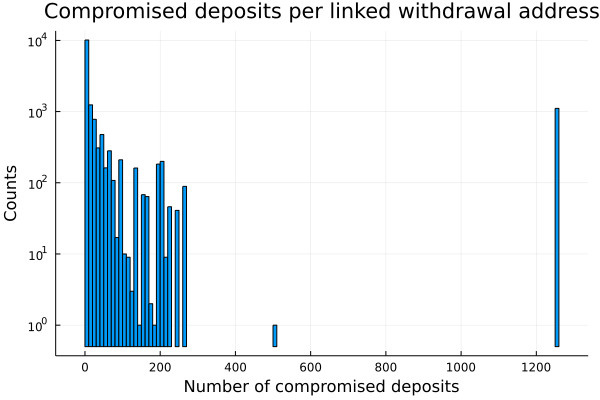

In [51]:
linked_deposits_counts = Dict()
for key in keys(w2d)
    linked_deposits_counts[key] = length(w2d[key])
end

histogram(collect(values(linked_deposits_counts)), legend=false, bins=200, yaxis=(:log10))
xlabel!("Number of compromised deposits")
ylabel!("Counts")
title!("Compromised deposits per linked withdrawal address")

## Heuristic 4 

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [38]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [39]:
# Import relevant packages.
using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [40]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

In [41]:
tornado_addresses = Dict(
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144" => "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334" => "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc" => "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936" => "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf" => "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291" => "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d" => "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b" => "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f" => "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1" => "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4" => "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003" => "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701" => "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af" => "5000000 cDAI"
    );

### Function summary: compare_transactions

Given two dictionaries, withdraw_dict and deposit_dict representing the total deposits and withdraws made by an address to each TCash pool, respectively, compares if the set of keys of both are equal and when they are, checks if all values in the deposit dictionary are equal or greater than each of the corresponding values of the withdraw dicionary. If this is the case, returns $True$, if not, $False$.

In [42]:
function compare_transactions(withdraws_dict, deposits_dict)
    for currency in keys(withdraws_dict)
        if !(deposits_dict[currency] >= withdraws_dict[currency])
            return false
        end
    end
    return true
end

compare_transactions (generic function with 1 method)

### Function summary: get_number_of_withdraws
Given a withdraw transaction and the total withdrawals data, the function get_number_of_withdraws returns the number of previous withdrawal transactions with the same address as the withdraw transaction.

In [43]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
    
    # The number of withdraws is initialized at 1 since the withdraw_transaction of the first argument is always present
    # in the withdrawal data. Also, the count should be 1 if there is no other transaction with the same address.
    
    n_withdraws = Dict(tornado_addresses[withdraw_transaction.tornado_cash_address] => 1)
    
    # This for loop counts the number of transactions with the same address. At the end, the total number is returned.
    # The count is done considering that the recipient_address of each of the transactions in the withdraw_transactions_df
    # is the same as the recipient_address of the withdraw_transaction input, and that the timestamp of the rows is earlier
    # than the withdraw_transaction input. 
    # The if clause also filters by the transaction hash, since we don't want to count the same transaction two times.
    
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && 
            (row.block_timestamp <= withdraw_transaction.block_timestamp) && 
            (row.hash != withdraw_transaction.hash)
            
            if haskey(n_withdraws, tornado_addresses[row.tornado_cash_address])
                n_withdraws[tornado_addresses[row.tornado_cash_address]] += 1
            else
                n_withdraws[tornado_addresses[row.tornado_cash_address]] = 1
            end
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

### Function summary: get_address_deposits

Given the deposit transactions DataFrame, returns a dictionary with every address of the deposit

In [44]:
function get_address_deposits(deposit_transactions_df, tornado_addresses)
    # unique_addresses = unique(deposit_transactions_df[!, "from_address"])
    
    addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :tornado_cash_address]), nrow => :count)
    
    addresses_and_deposit_dict = Dict()
    for row in eachrow(addresses_and_deposits_counts)
        if haskey(addresses_and_deposit_dict, row.from_address)
             if haskey(addresses_and_deposit_dict[row.from_address], tornado_addresses[row.tornado_cash_address])
                 addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] += row.count
             else
                addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] = row.count
             end
        else
            addresses_and_deposit_dict[row.from_address] = Dict(tornado_addresses[row.tornado_cash_address] => row.count)
        end
    end
    
    return addresses_and_deposit_dict
end

get_address_deposits (generic function with 1 method)

In [45]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 23504 entries:
  "0x23f11f0571e392390929ec909be393fd93e79eb6" => Dict("1 ETH"=>2)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  "0xa3a0a77d44ab389b1bbfdd6305a82a872449c8a1" => Dict("10 ETH"=>9, "1 ETH"=>8)
  "0x7b590b11f20f5e942f7b39f05b6827f4787cf435" => Dict("100000 DAI"=>1)
  "0x110790db185798abc9fc14570a60eab346ad6dbd" => Dict("1 ETH"=>1)
  ⋮                                            => ⋮

In [46]:
get_number_of_withdraws(withdraw_transactions_df[3,:], withdraw_transactions_df, tornado_addresses)

Dict{String, Int64} with 3 entries:
  "1000 USDC" => 2
  "100 ETH"   => 1
  "0.1 ETH"   => 1

In [47]:
d = Dict("1 ETH" => 93,
  "100 ETH" => 4,
  "1 WBTC" => 3,
  "0.1 ETH" => 1,
  "0.1 WBTC" => 1)

Dict{String, Int64} with 5 entries:
  "0.1 WBTC" => 1
  "1 ETH"    => 93
  "100 ETH"  => 4
  "1 WBTC"   => 3
  "0.1 ETH"  => 1

### Function summary: get_same_or_more_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same number of deposits. Returns an array with all the addresses that match these requirements.

In [48]:
function get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    filter(address_deposit -> (Set(keys(n_withdraws))) == Set(keys(last(address_deposit))) &&
                                    compare_transactions(n_withdraws, last(address_deposit)),
                                address_deposits) |> keys |> collect
    
end

get_same_or_more_number_of_deposits (generic function with 1 method)

In [49]:
get_same_or_more_number_of_deposits(d, address_deposits, tornado_addresses)

1-element Vector{Any}:
 "0x6e8df51931f8675cf7e12447e1fe25b26c8775c7"

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [50]:
function same_number_of_deposits_heuristic(withdraw_transaction, address_deposits, withdraw_transactions_df, tornado_addresses)
                                                              
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
        
    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    
    Ϛ = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    # The anonimity score P is computed.
    
    P = 1 - 1/length(Ϛ)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 1 method)

In [51]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    # An empty dictionary is initialized. It will be used to store the anonimity score associated with each transaction.
    
    tx_hash_and_anonimity_score = Dict()
    
    # Iterate over every row of the withdraw_transactions DataFrame and apply the function same_number_of_deposits_heuristic
    # For each transaction, the anonimity score is computed and appended to the dictionary.
    
    for withdraw_row ∈ eachrow(withdraw_transactions_df)
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, address_deposits, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    
    # The dictionary with the transaction hashes and scores is returned
    
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [52]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)


Dict{Any, Any} with 83782 entries:
  "0xebb9452b1368a3952ad3a4b07eb9218c078417a4ba94c8480717403befba3633" => 0.999543
  "0xe1ecd6266170da1e70cef21548d1f41b59ddbcdd57f8e18f571b0e9eded8aa56" => 0.999781
  "0xa3f64e7379d1129d91678e559894a3620108b34524ca8585089f7e468fed0cb6" => 0.995745
  "0x51ead89536e63c1d0c443e4c44039bf2644b2ca139df2b867f7a17b98d46168d" => 0.999778
  "0x004982c4e614d167780d97e29329437b9f185e37bdc3c2e62179be11d7ab4f10" => 0.999807
  ⋮                                                                    => ⋮

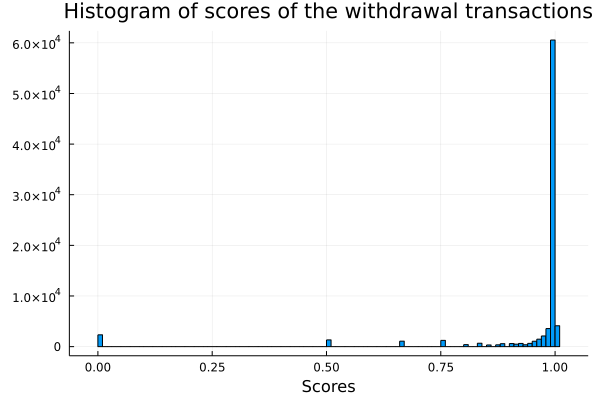

In [55]:
score_values = values(scores) |> collect
histogram(score_values, bins=100, legend=false, title="Histogram of scores of the withdrawal transactions", xlabel="Scores")